In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit

In [30]:
class Simulation:
    def __init__(self, A, initial_state, whatH):
        self.A = A
        self.initial_state = initial_state
        self.whatH = whatH
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega = sc.optimal_omegad(self.A)[0]*2*np.pi

        if self.whatH == 'H2':
            # Setup actual system
            self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 

    def H2(self):
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        # Create H_control with only specific off-diagonal elements
        H_control = self.sc.H_control.copy()
        # Zero out all elements first
        H_control[:] = 0

        # Keep only elements [0,2], [1,3], [2,4], [3,5] and their symmetric counterparts
        for i in range(len(H_control) - 2):
            # Keep the upper diagonal elements [i, i+2]
            H_control[i, i+2] = self.sc.H_control[i, i+2]
            # Make it symmetric by setting [i+2, i]
            H_control[i+2, i] = self.sc.H_control[i+2, i]

        H0 = qt.Qobj(H0) 
        H_control = qt.Qobj(H_control)
        H_rot = self.optimal_omega*np.kron(np.array([[0,0,0],[0,1,0],[0,0,2]]), np.identity(2)) + self.optimal_omega*np.kron(np.identity(3), np.array([[0,0],[0,1]])) 

        # H_rot = H0 + A/2*H_control
        H0_rot = H0.full() - H_rot+ self.A/2 * H_control.full()
        evals_rot, U = np.linalg.eigh(H0_rot)
        evals_rot, U = sort_eigenpairs(evals_rot, U)
        evals_rot = evals_rot - evals_rot[0]
        self.omega_c = evals_rot[1]
        Ud = U.T.conj()
        U = qt.Qobj(U)
        Ud = qt.Qobj(Ud)
        dressed00 = qt.Qobj(U[:,0])
        dressed01 = qt.Qobj(U[:,1])
        dressed10 = qt.Qobj(U[:,2])
        dressed11 = qt.Qobj(U[:,3])
        P10 = dressed10 * dressed10.dag()
        P11 = dressed11 * dressed11.dag()
        P00 = dressed00 * dressed00.dag()
        P01 = dressed01 * dressed01.dag()
        sigmaxc = np.kron(np.identity(3), np.array([[0,1],[1,0]]))
        sigmaxs = np.kron(np.array([[0,1,0],[1,0,0],[0,0,0]]), np.identity(2))
        sigmaxc = U@sigmaxc@Ud
        sigmaxs = U@sigmaxs@Ud
        initial00 = dressed00
        initial01 = dressed01
        initialpc = np.sqrt(1/2)*(dressed00 + dressed01)
        initialps = np.sqrt(1/2)*(dressed00 + dressed10)
        noise = np.diag(np.diag(self.sc.noise) - np.diag(self.sc.noise)[0])
        self.noise = qt.Qobj(noise)
        self.s = np.zeros([6,6], dtype=complex)
        self.s[:4,:4] = self.sc.s[:4,:4]
        if self.initial_state == '00':
            initial_state = initial00
            M = P10
        elif self.initial_state == '01':
            initial_state = initial01
            M = [P00,P01,P10,P11]
        elif self.initial_state == 'pc':
            initial_state = initialpc
            M = sigmaxc
        elif self.initial_state == 'ps':
            initial_state = initialps
            M = sigmaxs
        
        return qt.Qobj(H0.full()-H_rot), H_control , initial_state, M, self.noise
  
    def gaussian_ramp(self, t_rise, t_flat, t_down, amplitude):
        """
        Creates a time-dependent function using a Gaussian function that rises, 
        stays flat, and then falls.

        Args:
        t_rise (float): The time at which the function reaches the amplitude.
        t_flat (float): The duration for which the function stays at the amplitude.
        t_down (float): The time it takes for the function to fall back to zero.
        amplitude (float): The maximum amplitude of the Gaussian peak.

        Returns:
        function: A function of time 't' that implements the desired behavior.
        """
        # Define the standard deviation for the Gaussian edges
        sigma_rise = t_rise / 3  # Adjust sigma to make the function start close to zero at t=0
        sigma_down = t_down / 3  # Similar adjustment for the falling edge

        # Define the function using a closure to encapsulate the parameters
        def time_dependent_function(t):
            t_start_flat = t_rise  # Time when flat region starts
            t_end_flat = t_rise + t_flat  # Time when flat region ends
            
            if t <= t_start_flat:
                # Gaussian rise centered at t_rise
                return amplitude * np.exp(-((t - t_start_flat)**2) / (2 * sigma_rise**2)) - amplitude * np.exp(-((0 - t_start_flat)**2) / (2 * sigma_rise**2))
            elif t >= t_end_flat:
                # Gaussian fall centered at t_end_flat
                return amplitude * np.exp(-((t - t_end_flat)**2) / (2 * sigma_down**2)) - amplitude * np.exp(-((t_end_flat + t_down - t_end_flat)**2) / (2 * sigma_down**2))
            else:
                # Constant amplitude in the middle region
                return amplitude - amplitude * np.exp(-((0 - t_start_flat)**2) / (2 * sigma_rise**2))

        return time_dependent_function
    
    def analyze_and_fit_decay(self, simulation, time_points, avg_value, S0, ifplot=True):
        from scipy.optimize import curve_fit
        # Setup time points
        t_max = time_points[-1]
        N = t_max
        if simulation.initial_state == '00' or simulation.initial_state == '01':
            # Define exponential decay function with fixed offset of 1/2
            def exp_decay_fixed_offset(t, T):
                return 0.5 * (1 - np.exp(-t / T))
        elif simulation.initial_state == 'pc': 
            def exp_decay_fixed_offset(t, T):
                return np.exp(-t / T) * np.cos(simulation.omega_c * t)

        # Fit the data with exponential decay (fixed offset = 1/2)
        params, pcov = curve_fit(exp_decay_fixed_offset, time_points, avg_value, p0=[1000])
        T_fit = params[0]

        if ifplot:
            # Plot the results with the fit
            plt.figure(figsize=(5, 3))
            # std_value = np.std(result, axis=0)
            # plt.errorbar(time_points, avg_value, yerr=std_value, fmt='b-', label='Simulation data', capsize=3)
            plt.plot(time_points, avg_value, 'b-', label='Simulation data')
            plt.plot(time_points, exp_decay_fixed_offset(time_points, T_fit), 'r--', 
                        label=f'Fit: 0.5*(1+exp(-t/T)), T = {T_fit:.2f} ns')
            plt.xlabel('Time (ns)')
            plt.ylabel('Population')
            plt.title('Population dynamics with exponential fit (fixed offset = 1/2)')
            plt.legend()
            plt.grid(True)
            plt.show()

        # Print the fitted parameters
        if ifplot:
            print(f"Fitted T = {T_fit:.4f} ns")
        sc = simulation.sc
        S0P = S0 * (sc.omega_s_per - sc.omega_s) / 1e-6
        optimal_omega = simulation.optimal_omega
        sc = Hamiltonian(sc.phi_ex, sc.Ej, sc.Ec, [2,1])
        H0, H_control, initial_state, M, noise = simulation.H2()
        evals_rot, U = np.linalg.eigh((H0 + A/2*H_control).full())
        evals_rot, U = sort_eigenpairs(evals_rot, U)
        Ud = U.T.conj()

        me = (Ud@noise.full()@U)[0,2]
        detu = (evals_rot[2]-evals_rot[0])/2/np.pi
        rate = S0**2 / (detu) * (np.abs(me)*np.pi*np.sin(0.2*np.pi))**2 * 2
        estimated_time = 1 / rate
        if ifplot:
            print(f"Estimated T = {estimated_time:.4f} ns")
        analytical_T2 = 1/(2*S0P**2/0.1/4)
        if ifplot:
            print(f"Analytical T2 = {analytical_T2:.4f} ns")
        
        return T_fit, estimated_time, analytical_T2

In [3]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Define parameter ranges
A_values = np.linspace(0.5e-3 * 2 * np.pi, 10e-3 * 2 * np.pi, 10)
t_ramp_values = np.linspace(50, 300, 10)

initial_state_type = 'pc'
whatH = 'H2'
t_constant = 300

def simulate_single_point(A, t_ramp):
    """Simulate a single point in the parameter space"""
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()
    initial_state = np.sqrt(1/2) * qt.basis(6,0) + np.sqrt(1/2) * qt.basis(6,1) 
    
    func = simulation.gaussian_ramp(t_ramp, t_constant, t_ramp, A/2)
    H = [H0, [H_control, lambda t, args: func(t)]]
    tlist = np.linspace(0, 2*t_ramp+t_constant, 10000)
    
    # Use options to increase nsteps and improve integration stability
    opts = {'nsteps': int(2*t_ramp+t_constant*1), 'atol': 1e-10, 'rtol': 1e-8}
    result = qt.sesolve(H, initial_state, tlist, options=opts)
    
    avg_values = np.zeros(len(tlist))
    for j, t in enumerate(tlist):
        state_t = result.states[j]
        H_rot = H0 + func(t)*H_control
        evals, U = np.linalg.eigh(H_rot.full())
        evals, U = sort_eigenpairs(evals, U)
        ground_state = U[:,0]
        excited_state = U[:,1]
        ground_state = qt.Qobj(ground_state)
        excited_state = qt.Qobj(excited_state)
        avg_values[j] = (np.abs(ground_state.dag()*state_t)**2 + np.abs(excited_state.dag()*state_t)**2)
    
    return avg_values[int(t_ramp)],avg_values[-1]  # Return final fidelity

# Create parameter grid
A_grid, t_ramp_grid = np.meshgrid(A_values, t_ramp_values)
param_pairs = [(A_grid[i,j], t_ramp_grid[i,j]) for i in range(A_grid.shape[0]) for j in range(A_grid.shape[1])]

# Parallelize the computation
print(f"Running {len(param_pairs)} simulations...")
results = Parallel(n_jobs=-1)(delayed(simulate_single_point)(A, t_ramp) for A, t_ramp in param_pairs)

# Extract the two returned values
early_fidelities = [result[0] for result in results]
final_fidelities = [result[1] for result in results]



Running 100 simulations...


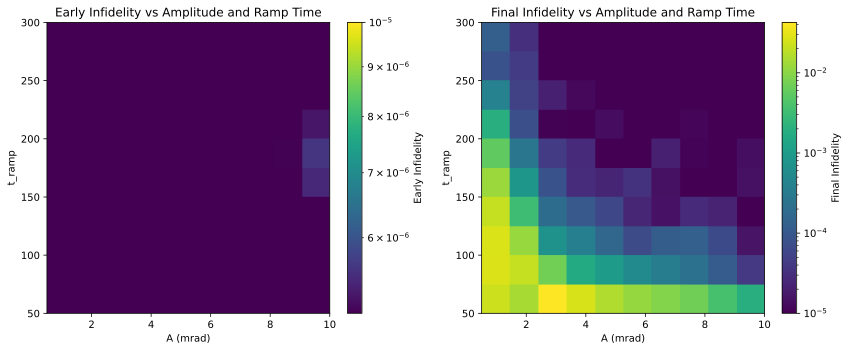

In [4]:
# Reshape results back to 2D grid
early_fidelity_grid = np.array(early_fidelities).reshape(A_grid.shape)
final_fidelity_grid = np.array(final_fidelities).reshape(A_grid.shape)

# Calculate infidelities (1 - fidelity)
early_infidelity_grid = 1 - early_fidelity_grid
final_infidelity_grid = 1 - final_fidelity_grid

from matplotlib.colors import LogNorm

# Create 2D plots for both early and final infidelities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5))

# Early infidelity plot
im1 = ax1.imshow(early_infidelity_grid, extent=[A_values[0]/(2*np.pi)*1e3, A_values[-1]/(2*np.pi)*1e3, 
                                         t_ramp_values[0], t_ramp_values[-1]], 
                aspect='auto', origin='lower' , cmap='viridis', norm=LogNorm(vmin=1e-5))
plt.colorbar(im1, ax=ax1, label='Early Infidelity')
ax1.set_xlabel('A (mrad)')
ax1.set_ylabel('t_ramp') 
ax1.set_title('Early Infidelity vs Amplitude and Ramp Time')

# Final infidelity plot
im2 = ax2.imshow(final_infidelity_grid, extent=[A_values[0]/(2*np.pi)*1e3, A_values[-1]/(2*np.pi)*1e3, 
                                         t_ramp_values[0], t_ramp_values[-1]], 
                aspect='auto', origin='lower', cmap='viridis', norm=LogNorm(vmin=1e-5))
plt.colorbar(im2, ax=ax2, label='Final Infidelity')
ax2.set_xlabel('A (mrad)')
ax2.set_ylabel('t_ramp') 
ax2.set_title('Final Infidelity vs Amplitude and Ramp Time')

plt.tight_layout()
plt.show()


In [ ]:
def white_noise(A):
    """
    Measure T1 and T2 times for a given amplitude A.
    
    Parameters:
    A : float
        Amplitude parameter
        
    Returns:
    tuple : (T1_fitted, T2_fit)
        Fitted T1 and T2 times
    """
    # Perform quantum simulation with noise trajectories
    from qutip import sesolve, basis, sigmaz, sigmax
    from joblib import Parallel, delayed
    import matplotlib.pyplot as plt

    gamma = 1/(2e4)

    options = {'rtol': 1e-12, 'atol': 1e-12}
    # T1 measurement (01 -> 00 decay)
    initial_state_type = '01'
    whatH = 'H2'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()
    P00, P01, P10, P11 = M

    t_list = np.linspace(0, 10000, 20000)
    H = [H0 + A/2*H_control]
    L = np.sqrt(gamma) * qt.Qobj(simulation.s)
    c_ops = [L]

    result = qt.mesolve(H, initial_state, t_list, c_ops, options=options)

    avg_values_P00 = [qt.expect(P00, state) for state in result.states]

    def fit1(t, T1):
        return 1 - np.exp(-t / T1)

    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(fit1, t_list, avg_values_P00)
    T1_fitted = popt[0]

    # T2 measurement (superposition state decay)
    initial_state_type = 'pc'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()

    t_list = np.linspace(0, 30000, 20000)

    result = qt.mesolve(H, initial_state, t_list, c_ops, options=options)

    avg_values_Pxc = [qt.expect(M, state) for state in result.states]
    def T2fit(t, T2):
        return np.exp(-t / T2) * np.cos(simulation.omega_c * t)

    popt, pcov = curve_fit(T2fit, t_list, avg_values_Pxc, p0=[1e6])
    T2_fit = popt[0]
    dephasing_rate1 = 1/T2_fit - 1/T1_fitted/2
    evals, U = np.linalg.eigh((H0 + A/2*H_control).full())
    evals, U = sort_eigenpairs(evals, U)
    Ud = U.conj().T
    dephasing_rate2 = (np.abs((Ud@simulation.s@U))[2,0]**2/2 + np.abs((Ud@simulation.s@U))[3,1]**2/2 + (np.abs((Ud@simulation.s@U))[1,1] - np.abs((Ud@simulation.s@U))[0,0])**2/2)*gamma
    dephasing_rate3 = gamma*(((2*A/(0.1*2*np.pi))**(2/3)/4)**2 + (0.01*(0.1*2*np.pi/(2*A))**(1/3))**2/2)
    return dephasing_rate1, dephasing_rate2, dephasing_rate3


In [7]:
import os

# Set environment variables to disable threading
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

A_values = np.linspace(0.1e-3, 5e-3, 20) * 2 * np.pi
dephasing_rates1 = []
dephasing_rates2 = []
dephasing_rates3 = []

from joblib import Parallel, delayed

results = Parallel(n_jobs=-1)(delayed(white_noise)(A) for A in A_values)

for rate1, rate2, rate3 in results:
    dephasing_rates1.append(rate1)
    dephasing_rates2.append(rate2)
    dephasing_rates3.append(rate3)

dephasing_rates1 = np.array(dephasing_rates1)
dephasing_rates2 = np.array(dephasing_rates2)
dephasing_rates3 = np.array(dephasing_rates3)


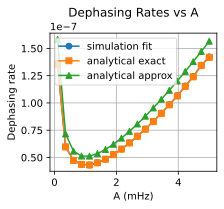

In [8]:
plt.figure(figsize=(3, 2.5))
plt.plot(A_values/(2*np.pi)*1e3, dephasing_rates1, 'o-', label='simulation fit')
plt.plot(A_values/(2*np.pi)*1e3, dephasing_rates2, 's-', label='analytical exact')
plt.plot(A_values/(2*np.pi)*1e3, dephasing_rates3, '^-', label='analytical approx')
plt.xlabel('A (mHz)')
plt.ylabel('Dephasing rate')
plt.title('Dephasing Rates vs A')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
def simulate_colored_noise_dephasing(A, S0, t_max, num_realizations, initial_state_type):
    """
    Simulate dephasing due to colored noise for given parameters.
    
    Parameters:
    -----------
    A : float
        Coupling strength
    S0 : float
        Noise amplitude
    t_max : int
        Maximum time in ns
    num_realizations : int
        Number of noise realizations
    
    Returns:
    --------
    tuple
        (time_points, result) where result is array of shape (num_realizations, N)
    """
    # T1 measurement (01 -> 00 decay)
    initial_state_type = '01'
    whatH = 'H2'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()
    if initial_state_type == '00':
        P = M
    elif initial_state_type == '01':
        _, _,_ ,P = M
    # Initialize arrays to store results
    N = t_max
    time_points = np.linspace(0, t_max, N)

    sample_rate = 1        # per ns
    tnoise_max = int(1e5)             # number of samples
    relative_PSD_strength = S0**2
    ifwhite = False               # True for white noise, False for 1/f noise
    
    gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
    trajs = gn.generate_colored_noise()

    def simulate_trajectory(i):
        # Create Hamiltonian with increased nsteps for better integration
        traj = np.cos(simulation.phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(simulation.phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
        H = [H0 + A/2*H_control, [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
        
        # Use options to increase nsteps and improve integration stability
        opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-10}
        result = qt.sesolve(H, initial_state, time_points, options=opts)
        avg_values = np.zeros(len(time_points))
        
        for j, t in enumerate(time_points):
            state_t = result.states[j]
            avg_values[j] = qt.expect(P, state_t) 
        return avg_values

    result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

    # Convert to numpy array for easier analysis
    result = np.array(result)
    
    return time_points, simulation, result, S0

# Example usage with specific parameters
initial_state_type = '00'
A_values = [1e-3 * 2 * np.pi, 3e-3 * 2 * np.pi, 5e-3 * 2 * np.pi]
S0_values = np.logspace(-6, -5, 10)  # 10 points from 1e-6 to 1e-5
t_max = 10000
num_realizations = 100

# Store results for plotting
T2_results = {}

# Loop over A values
for A in A_values:
    T2_fit_list = []
    T2_exact_list = []
    T2_app_list = []
    
    # Loop over S0 values
    for S0 in S0_values:
        time_points, simulation, result, S0_used = simulate_colored_noise_dephasing(A, S0, t_max, num_realizations, initial_state_type)
        avg_values = np.mean(result, axis=0)
        T2_fit, T2_exact, T2_app = simulation.analyze_and_fit_decay(simulation, time_points, avg_values, S0, ifplot=False)
        
        T2_fit_list.append(T2_fit)
        T2_exact_list.append(T2_exact)
        T2_app_list.append(T2_app)
    
    T2_results[A] = {
        'T2_fit': T2_fit_list,
        'T2_exact': T2_exact_list,
        'T2_app': T2_app_list
    }

# Plot results
plt.figure(figsize=(10, 6))
for A in A_values:
    plt.semilogx(S0_values, T2_results[A]['T2_fit'], 'o-', label=f'A = {A/(2*np.pi)*1e3:.1f} mHz')

plt.xlabel('S0')
plt.ylabel('T2 (ns)')
plt.title('T2 vs S0 for different A values (initial_state = 00)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

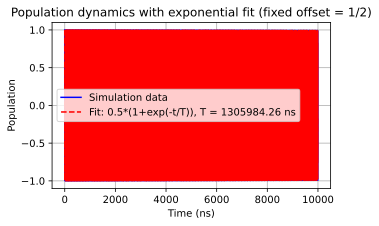

Fitted T = 1305984.2650 ns
Estimated T = -1011949.2457 ns
Analytical T2 = 1013553.1698 ns


np.float64(5.270834352559045e-07)

In [17]:
def measure_T1_and_T2_star(A, S0, t_max, num_realizations):
    """
    Measure T1 and T2* for given parameters and return pure dephasing rate.
    
    Parameters:
    A: Drive amplitude
    S0: Noise strength
    t_max: Maximum simulation time
    num_realizations: Number of noise realizations
    
    Returns:
    Pure dephasing rate (1/T2* - 1/(2*T1))
    """
    sample_rate = 1        # per ns
    tnoise_max = int(1e5)             # number of samples
    relative_PSD_strength = S0**2
    ifwhite = False               # True for white noise, False for 1/f noise
    gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
    trajs = gn.generate_colored_noise()

    # Define parameter ranges
    gamma = 1/(2e4)
    
    # T1 measurement (01 -> 00 decay)
    initial_state_type = '01'
    whatH = 'H2'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()
    P00, P01, P10, P11 = M

    L = np.sqrt(gamma) * qt.Qobj(simulation.s)
    c_ops = [L]

    time_points = np.linspace(0, 1000, 1000)
    def simulate_trajectory(i):
        traj = np.cos(simulation.phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(simulation.phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
        H = [H0 + A/2*H_control, [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
        opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-10}
        result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)
        avg_values = np.zeros(len(time_points))
        
        for j, t in enumerate(time_points):
            state_t = result.states[j]
            avg_values[j] = qt.expect(P00, state_t) 
        return avg_values

    result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))
    # Convert to numpy array for easier analysis
    result = np.array(result)
    avg_values  =   np.mean(result, axis=0)    
    def fit1(t, T1):
        return 1 - np.exp(-t / T1)

    popt, pcov = curve_fit(fit1, time_points, avg_values)
    T1_fitted = popt[0]

    # T2* measurement (pc -> pc decay)
    initial_state_type = 'pc'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()

    time_points = np.linspace(0, t_max, 20000)
    def simulate_trajectory(i):
        traj = np.cos(simulation.phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(simulation.phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
        H = [H0 + A/2*H_control, [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
        opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-10}
        result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)
        avg_values = np.zeros(len(time_points))
        
        for j, t in enumerate(time_points):
            state_t = result.states[j]
            avg_values[j] = qt.expect(M, state_t) 
        return avg_values

    result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

    # Convert to numpy array for easier analysis
    result = np.array(result)
    avg_value = np.mean(result, axis=0)
    T2,_,_ = simulation.analyze_and_fit_decay(simulation, time_points, avg_value, S0)
    
    return (1/T2 - 1/T1_fitted/2)

# Parameter sweep
A_values = [1e-3 * 2 * np.pi, 3e-3 * 2 * np.pi, 5e-3 * 2 * np.pi]
S0_values = np.logspace(-6, -5, 10)  # 10 points from 1e-6 to 1e-5
t_max = 10000
num_realizations = 100

# Store results
results = {}

# Sweep over A values
for A in A_values:
    rates = []
    for S0 in S0_values:
        print(f"Computing for A = {A/(2*np.pi):.3e}, S0 = {S0:.3e}")
        rate = measure_T1_and_T2_star(A, S0, t_max, num_realizations)
        rates.append(rate)
    results[A] = rates

# Plot results
plt.figure(figsize=(10, 6))
for A in A_values:
    plt.loglog(S0_values, results[A], 'o-', label=f'A = {A/(2*np.pi):.1e}')

plt.xlabel('S0')
plt.ylabel('Pure Dephasing Rate (1/s)')
plt.title('Pure Dephasing Rate vs S0 for Different Drive Amplitudes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

results